In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Need to do: K-fold Cross-Validation for both models, within training set
- Need to also do feature importance analysis with Decision Tree and XGBoost

In [2]:
df = pd.read_csv("final_dataset.csv")
df.head()

,name,year,avg_ageYrs,avg_seniorityYrs,RHP,avg_K,avg_W,avg_HR,avg_outs,WAR
0,A.J. Achter,2014,26.139717,0.032575,1.0,0.000465,0.000094,0.000131,0.008322,-0.134375
1,A.J. Achter,2015,26.951243,0.844101,1.0,0.001935,0.000917,0.000698,0.018676,-0.172119
2,A.J. Achter,2016,27.910348,1.803205,1.0,0.002283,0.000633,0.003974,0.014374,-0.423944
3,A.J. Alexy,2021,23.356055,0.019505,1.0,0.001139,0.000494,0.000073,0.003398,-0.032592
4,A.J. Alexy,2022,24.280294,0.840734,1.0,0.000988,0.000480,0.000150,0.003811,-0.193977


Train a model to predict the WAR for the year
- where each observation contains the aggregated (average, mode, etc.) key stats of a player for a given year, followed by the corresponding WAR

Set X and y

In [3]:
from sklearn.model_selection import train_test_split

In [4]:
# construct X
X = df.iloc[:, 2:-1]
X.head()

,avg_ageYrs,avg_seniorityYrs,RHP,avg_K,avg_W,avg_HR,avg_outs
0,26.139717,0.032575,1.0,0.000465,0.000094,0.000131,0.008322
1,26.951243,0.844101,1.0,0.001935,0.000917,0.000698,0.018676
2,27.910348,1.803205,1.0,0.002283,0.000633,0.003974,0.014374
3,23.356055,0.019505,1.0,0.001139,0.000494,0.000073,0.003398
4,24.280294,0.840734,1.0,0.000988,0.000480,0.000150,0.003811


In [5]:
# construct y
y = df["WAR"]
y.head()

0   -0.134375
1   -0.172119
2   -0.423944
3   -0.032592
4   -0.193977
Name: WAR, dtype: float64

In [6]:
# split the dataset into a training set and testing set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0)
X_train.head()

,avg_ageYrs,avg_seniorityYrs,RHP,avg_K,avg_W,avg_HR,avg_outs
6436,29.109772,5.859772,1.0,0.004180,0.000168,0.000348,0.015696
4701,26.058054,4.253109,1.0,0.000822,0.000165,0.000202,0.008584
3443,28.633797,8.710835,1.0,0.001215,0.000271,0.000121,0.004142
440,29.686198,7.230268,0.0,0.002393,0.000123,0.000039,0.006961
8308,26.493214,0.044349,1.0,0.003861,0.000585,0.000039,0.010245


Setup, Fit, Test Model: Decision Tree

In [7]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

In [8]:
# model: decision tree (regressor)
decision_tree = DecisionTreeRegressor(random_state = 0)

# define paramaters to tune via cross-validation
param_grid = {
    'max_depth': [3, 5, 10, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

tree_grid_search = GridSearchCV(
    estimator = decision_tree,
    param_grid = param_grid,
    cv = 5, # number of cv-folds
    scoring = "neg_mean_squared_error", # sci-kit learn has the convention of maximizing, not minimizing
    n_jobs = -1
)

# train model
tree_grid_search.fit(X_train, y_train)

# Get best parameters
print("Best Parameters:", tree_grid_search.best_params_)

# Get best score (negative MSE, so take absolute value)
print("Best Cross-Validation MSE:", abs(tree_grid_search.best_score_))

Best Parameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best Cross-Validation MSE: 0.8327815605382151


In [9]:
# evaluate best model on test set
best_decision_tree = tree_grid_search.best_estimator_

# make predictions
y_pred = best_decision_tree.predict(X_test)

# compute testing error metric
test_mse = mean_squared_error(y_test, y_pred)
print("Test MSE:", test_mse)

Test MSE: 0.8339016437689177


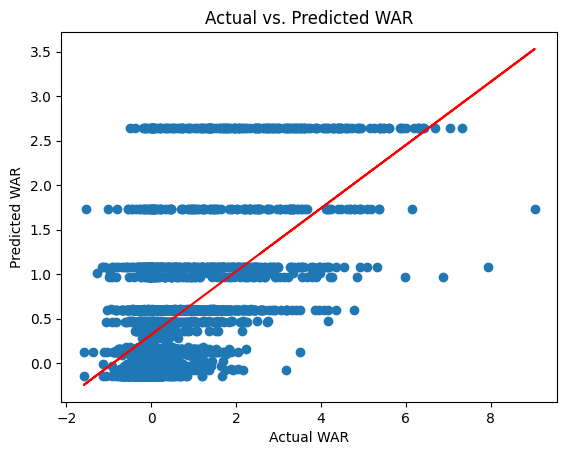

In [10]:
# Scatter plot
plt.scatter(y_test, y_pred)

slope, intercept = np.polyfit(y_test, y_pred, 1)  # 1st-degree polynomial (linear)

# Regression line
plt.plot(y_test, slope * y_test + intercept, color="red")

plt.xlabel("Actual WAR")
plt.ylabel("Predicted WAR")
plt.title("Actual vs. Predicted WAR")
plt.show()

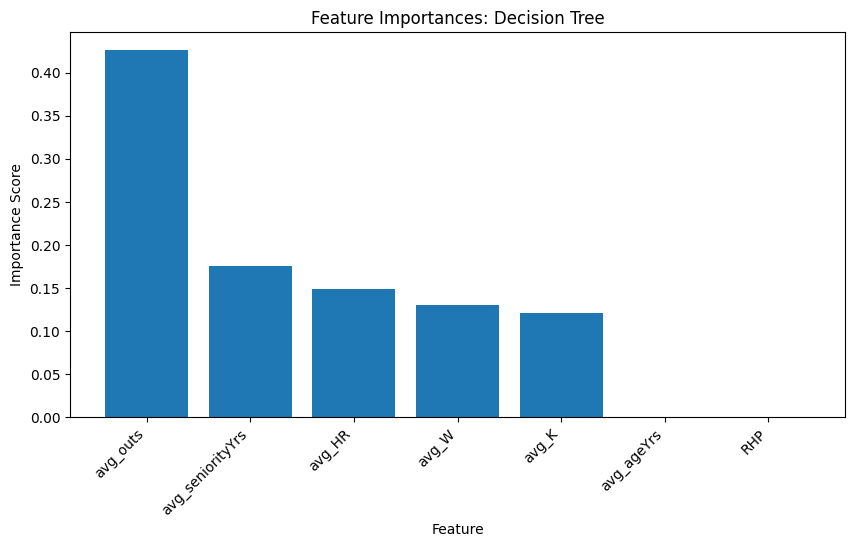

In [11]:
# feature importances

# get feature importances
feature_importances = best_decision_tree.feature_importances_

# get feature names
feature_names = X.columns

# sort feature importances
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_idx], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importances: Decision Tree")
plt.show()
#print(feature_importances[sorted_idx])

Setup, Fit, Test Model: XG Boost 
- (Ensemble of Decision Trees, where each new Decision Tree tries to correct the errors of the previous)

In [12]:
from xgboost import XGBRegressor

In [13]:
# model: XGBoost ensemble model (regressor)
xgb = XGBRegressor(objective = "reg:squarederror", random_state = 0)

# Define hyperparameters to tune
param_grid = {
    'n_estimators': [10, 30, 50],  # Number of boosting rounds
    'max_depth': [3, 5, 10],  # Tree depth
    'learning_rate': [0.01, 0.1, 0.2],  # Step size
    'colsample_bytree': [0.8, 1.0]  # Fraction of features per tree
}

xgb_grid_search = GridSearchCV(
    estimator = xgb, 
    param_grid = param_grid, 
    cv = 5,
    scoring = 'neg_mean_squared_error',
    n_jobs = -1
)

# train model
xgb_grid_search.fit(X_train, y_train)

# Get best parameters
print("Best Parameters:", xgb_grid_search.best_params_)

# Get best cross-validation score (convert to positive MSE)
print("Best Cross-Validation MSE:", abs(xgb_grid_search.best_score_))


Best Parameters: {'colsample_bytree': 0.8, 'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 50}
Best Cross-Validation MSE: 0.7046947101373389


In [14]:
# evaluate best model on test set
best_xgboost = xgb_grid_search.best_estimator_

# make predictions
y_pred = best_xgboost.predict(X_test)
y_pred[:5]

# compute testing error metric
mse_xgb = mean_squared_error(y_test, y_pred)
mse_xgb

np.float64(0.7112092549653402)

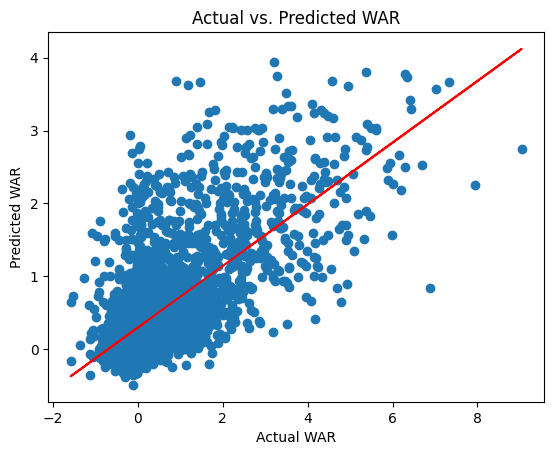

In [15]:
# Scatter plot
plt.scatter(y_test, y_pred)

slope, intercept = np.polyfit(y_test, y_pred, 1)  # 1st-degree polynomial (linear)

# Regression line
plt.plot(y_test, slope * y_test + intercept, color="red")

plt.xlabel("Actual WAR")
plt.ylabel("Predicted WAR")
plt.title("Actual vs. Predicted WAR")
plt.show()

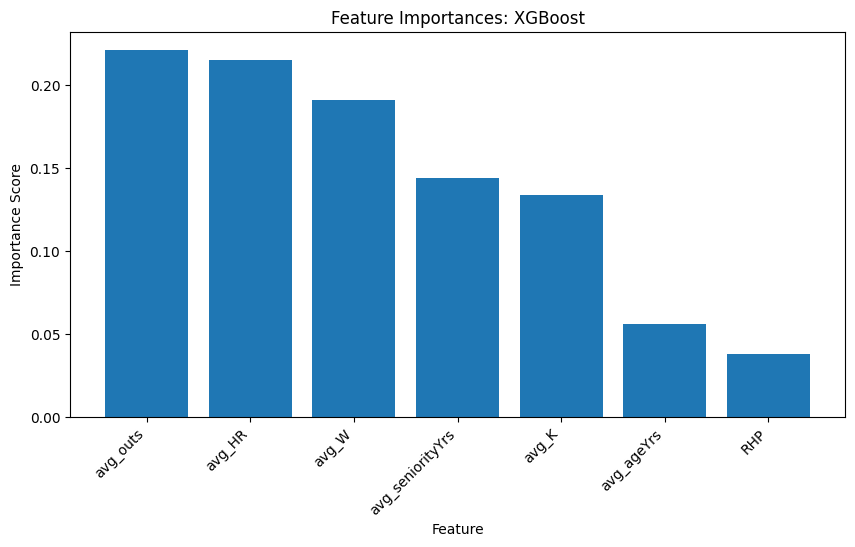

In [16]:
# feature importances

# get feature importances
feature_importances = best_xgboost.feature_importances_

# get feature names
feature_names = X.columns

# sort feature importances
sorted_idx = np.argsort(feature_importances)[::-1]

plt.figure(figsize=(10, 5))
plt.bar(range(len(feature_importances)), feature_importances[sorted_idx], align='center')
plt.xticks(range(len(feature_importances)), np.array(feature_names)[sorted_idx], rotation=45, ha='right')
plt.xlabel("Feature")
plt.ylabel("Importance Score")
plt.title("Feature Importances: XGBoost")
plt.show()